In [45]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import geopandas as gpd

# **Introduction + Data analysis and visualization**
---

We will start by loading the data and inspect its columns and first few rows to understand its structure.

In [46]:
# Load the data
df = pd.read_csv('EVChargingStationUsage.csv')

/var/folders/c_/q2yk81hd0zj7jnx_b5275pzh0000gn/T/ipykernel_27589/2559826331.py:2: DtypeWarning: Columns (29,30,32) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('EVChargingStationUsage.csv')


In [47]:
# Display basic information about the data
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 259415 entries, 0 to 259414
Data columns (total 33 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   Station Name                     259415 non-null  object 
 1   MAC Address                      259415 non-null  object 
 2   Org Name                         259415 non-null  object 
 3   Start Date                       259415 non-null  object 
 4   Start Time Zone                  259415 non-null  object 
 5   End Date                         259415 non-null  object 
 6   End Time Zone                    259415 non-null  object 
 7   Transaction Date (Pacific Time)  259206 non-null  object 
 8   Total Duration (hh:mm:ss)        259415 non-null  object 
 9   Charging Time (hh:mm:ss)         259415 non-null  object 
 10  Energy (kWh)                     259415 non-null  float64
 11  GHG Savings (kg)                 259415 non-null  float64
 12  Ga

In [48]:
# Display the first few rows to inspect the data
print(df.head())

                 Station Name          MAC Address           Org Name  \
0  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
1  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
2  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
3  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   
4  PALO ALTO CA / HAMILTON #1  000D:6F00:015A:9D76  City of Palo Alto   

        Start Date Start Time Zone         End Date End Time Zone  \
0  7/29/2011 20:17             PDT  7/29/2011 23:20           PDT   
1   7/30/2011 0:00             PDT   7/30/2011 0:02           PDT   
2   7/30/2011 8:16             PDT  7/30/2011 12:34           PDT   
3  7/30/2011 14:51             PDT  7/30/2011 16:55           PDT   
4  7/30/2011 18:51             PDT  7/30/2011 20:03           PDT   

  Transaction Date (Pacific Time) Total Duration (hh:mm:ss)  \
0                 7/29/2011 23:20                   3:03:32   
1                  7

We now know the structure of the data, and we can start to analyze it. We need to identify and handle missing or corrupted values.

In [49]:
# Convert date columns to datetime format
for col in ['Start Date', 'End Date', 'Transaction Date (Pacific Time)']:
    df[col] = pd.to_datetime(df[col], errors='coerce')

# Check for missing or inconsistent station data (Station Name, Latitude, Longitude)
station_data = df[['Station Name', 'Latitude', 'Longitude']].drop_duplicates()

# Summary of missing or inconsistent data
missing_summary = {
    "Total Stations": len(station_data),
    "Missing Latitude/Longitude": station_data.isnull().sum(),
    "Unique Station Names": station_data['Station Name'].nunique(),
}

# Aggregating average daily energy consumption per station
df['Date'] = df['Start Date'].dt.date  # Extract date for daily aggregation
avg_daily_energy = df.groupby(['Station Name', 'Latitude', 'Longitude', 'Date'])['Energy (kWh)'].sum().reset_index()
station_avg_energy = avg_daily_energy.groupby(['Station Name', 'Latitude', 'Longitude'])['Energy (kWh)'].mean().reset_index()

# Rename columns for clarity
station_avg_energy.rename(columns={'Energy (kWh)': 'Avg Daily Energy (kWh)'}, inplace=True)

missing_summary, station_avg_energy.head()

({'Total Stations': 70,
  'Missing Latitude/Longitude': Station Name    0
  Latitude        0
  Longitude       0
  dtype: int64,
  'Unique Station Names': 47},
                 Station Name   Latitude   Longitude  Avg Daily Energy (kWh)
 0  PALO ALTO CA / BRYANT # 1  37.446651 -122.161919               10.025636
 1   PALO ALTO CA / BRYANT #1  37.446373 -122.162331               12.214726
 2   PALO ALTO CA / BRYANT #1  37.446613 -122.162308               35.331154
 3   PALO ALTO CA / BRYANT #1  37.446651 -122.161919                9.008000
 4   PALO ALTO CA / BRYANT #2  37.446373 -122.162331               11.288037)

In [50]:
# Standardizing station names based on coordinates
# Grouping by coordinates and assigning a representative name to each unique coordinate set
station_mapping = (
    station_avg_energy.groupby(['Latitude', 'Longitude'])['Station Name']
    .agg(lambda x: x.value_counts().idxmax())  # Most common name for each coordinate pair
    .reset_index()
)

# Mapping consistent names back to the original dataset
station_name_map = dict(zip(zip(station_mapping['Latitude'], station_mapping['Longitude']), station_mapping['Station Name']))
df['Standardized Station Name'] = df.apply(
    lambda row: station_name_map.get((row['Latitude'], row['Longitude']), row['Station Name']), axis=1
)

# Re-aggregate average daily energy with standardized station names
avg_daily_energy_standardized = df.groupby(['Standardized Station Name', 'Latitude', 'Longitude', 'Date'])['Energy (kWh)'].sum().reset_index()
station_avg_energy_standardized = avg_daily_energy_standardized.groupby(['Standardized Station Name', 'Latitude', 'Longitude'])['Energy (kWh)'].mean().reset_index()

# Rename columns for clarity
station_avg_energy_standardized.rename(columns={'Energy (kWh)': 'Avg Daily Energy (kWh)'}, inplace=True)

station_avg_energy_standardized.head()

,Standardized Station Name,Latitude,Longitude,Avg Daily Energy (kWh)
0,PALO ALTO CA / BRYANT # 1,37.446651,-122.161919,9.438538
1,PALO ALTO CA / BRYANT #1,37.446373,-122.162331,20.219869
2,PALO ALTO CA / BRYANT #1,37.446613,-122.162308,35.323029
3,PALO ALTO CA / BRYANT #2,37.446510,-122.162140,35.883270
4,PALO ALTO CA / BRYANT #3,37.446583,-122.162109,27.548225


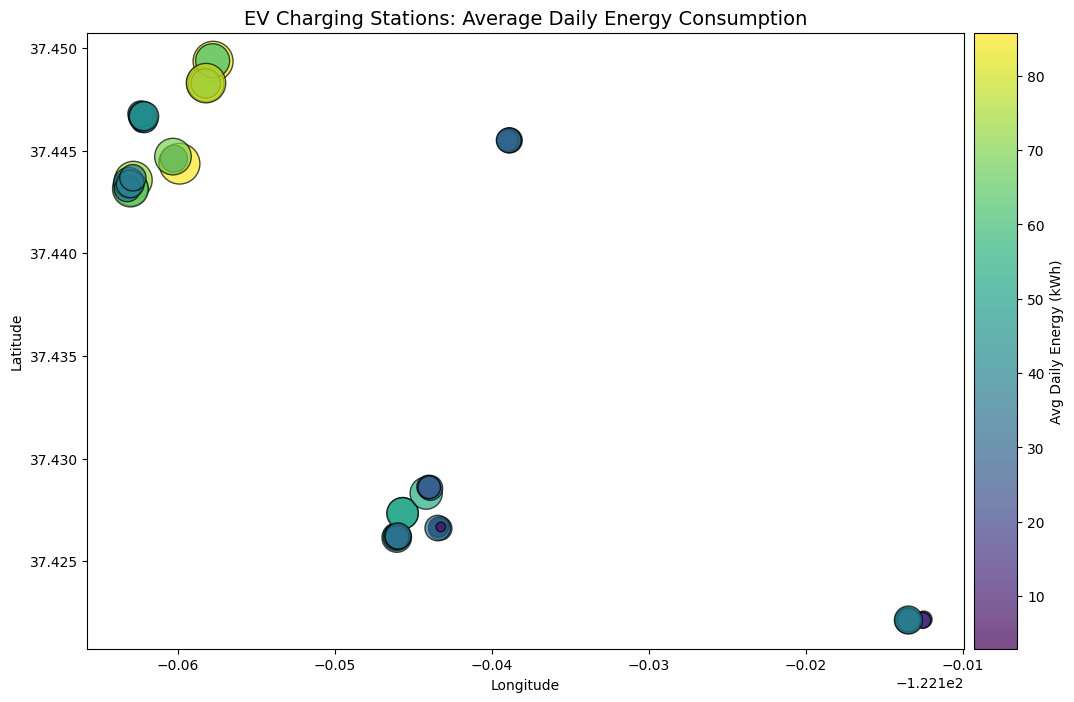

In [53]:
# Load a world map for context
#world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Extract relevant data for plotting
bubble_data = station_avg_energy_standardized.copy()

# Plotting the bubble map
fig, ax = plt.subplots(figsize=(12, 8))
#world.
plt.plot(ax=ax, color='lightgrey', edgecolor='black')

# Adding the bubble plot
bubble = ax.scatter(
    bubble_data['Longitude'], bubble_data['Latitude'],
    s=bubble_data['Avg Daily Energy (kWh)'] * 10,  # Scale bubble size
    c=bubble_data['Avg Daily Energy (kWh)'], cmap='viridis', alpha=0.7, edgecolor='k'
)

# Color bar for energy levels
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)
plt.colorbar(bubble, cax=cax, label='Avg Daily Energy (kWh)')

# Titles and labels
ax.set_title('EV Charging Stations: Average Daily Energy Consumption', fontsize=14)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

plt.show()

In [57]:
# Extract the hour from the Start Date
df['Start Hour'] = df['Start Date'].dt.hour

# Group by the hour of the day and calculate average energy consumption
hourly_energy = df.groupby('Start Hour')['Energy (kWh)'].mean().reset_index()

# Rename columns for clarity
hourly_energy.rename(columns={'Energy (kWh)': 'Avg Energy (kWh)'}, inplace=True)

hourly_energy

,Start Hour,Avg Energy (kWh)
0,0,16.163836
1,1,17.336277
2,2,15.551026
3,3,13.811987
4,4,8.910069
5,5,7.981668
6,6,9.894188
7,7,9.816590
8,8,9.504493
9,9,9.401263


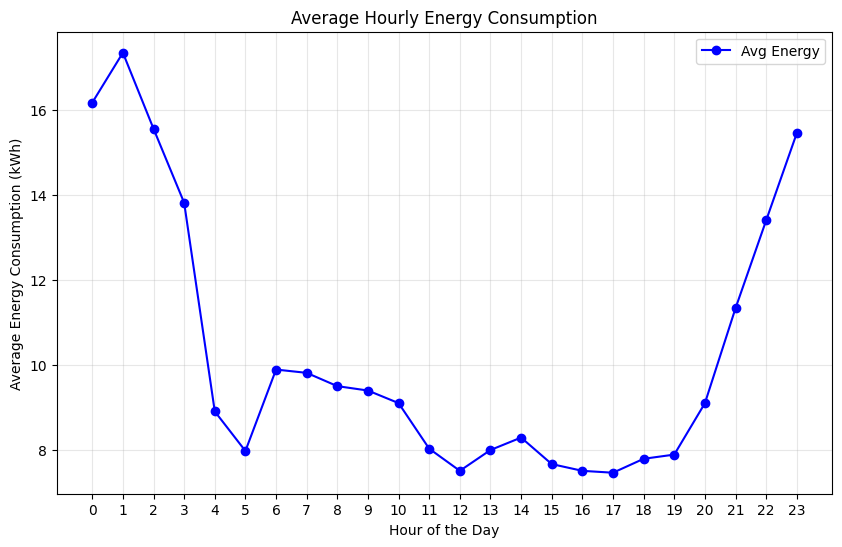

In [61]:
# Assuming 'data' is your DataFrame
# Extract the hour from the Start Date column
df['Start Hour'] = df['Start Date'].dt.hour

# Group by the hour of the day and calculate average energy consumption
hourly_energy = df.groupby('Start Hour')['Energy (kWh)'].mean().reset_index()

# Rename columns for clarity
hourly_energy.rename(columns={'Energy (kWh)': 'Avg Energy (kWh)'}, inplace=True)

# Plot the data
plt.figure(figsize=(10, 6))
plt.plot(hourly_energy['Start Hour'], hourly_energy['Avg Energy (kWh)'], marker='o', color='b', label='Avg Energy')

# Add labels, title, and legend
plt.xlabel('Hour of the Day')
plt.ylabel('Average Energy Consumption (kWh)')
plt.title('Average Hourly Energy Consumption')
plt.xticks(range(0, 24))  # Ensure all hours are labeled
plt.grid(alpha=0.3)
plt.legend()
plt.show()

Preparing the data for user-level analysis.

In [64]:
# Calculate hourly energy usage and charger occupation for each user
df['Start Hour'] = df['Start Date'].dt.hour
df['Occupation (hours)'] = (df['End Date'] - df['Start Date']).dt.total_seconds() / 3600

user_hourly_data = df.groupby(['User ID', 'Start Hour']).agg({
    'Energy (kWh)': 'mean',
    'Occupation (hours)': 'mean'
}).reset_index()

# Pivot the data to create time-series for each user
user_hourly_energy = user_hourly_data.pivot(index='User ID', columns='Start Hour', values='Energy (kWh)').fillna(0)
user_hourly_occupation = user_hourly_data.pivot(index='User ID', columns='Start Hour', values='Occupation (hours)').fillna(0)

print(user_hourly_occupation.head())

Start Hour   0    1    2    3    4         5         6         7         8   \
User ID                                                                       
0.0         0.0  0.0  0.0  0.0  0.0  5.066667  3.638095  3.550833  3.314167   
102.0       0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000   
107.0       0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000   
111.0       0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  2.616667   
140.0       0.0  0.0  0.0  0.0  0.0  0.000000  0.000000  0.000000  0.000000   

Start Hour        9   ...         14        15        16        17        18  \
User ID               ...                                                      
0.0         2.677451  ...  38.119643  1.964035  2.040000  2.602604  2.218182   
102.0       0.000000  ...   0.000000  2.725000  0.000000  0.000000  0.000000   
107.0       0.000000  ...   0.733333  0.000000  0.000000  0.000000  2.666667   
111.0       4.483333  ...   1.133333  0.000000

Combining energy and occupation data for clustering

In [73]:
# Normalize the data
scaler = StandardScaler()
normalized_energy = scaler.fit_transform(user_hourly_energy)
normalized_occupation = scaler.fit_transform(user_hourly_occupation)

# Combine features
user_features = np.hstack([normalized_energy, normalized_occupation])

In [74]:
# Apply k-means clustering
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(user_features)

# Assign cluster labels to each user
user_hourly_energy['Cluster'] = clusters

The clusters is grouped by the user ID and the start hour to calculate the average energy consumption and occupation for each cluster.

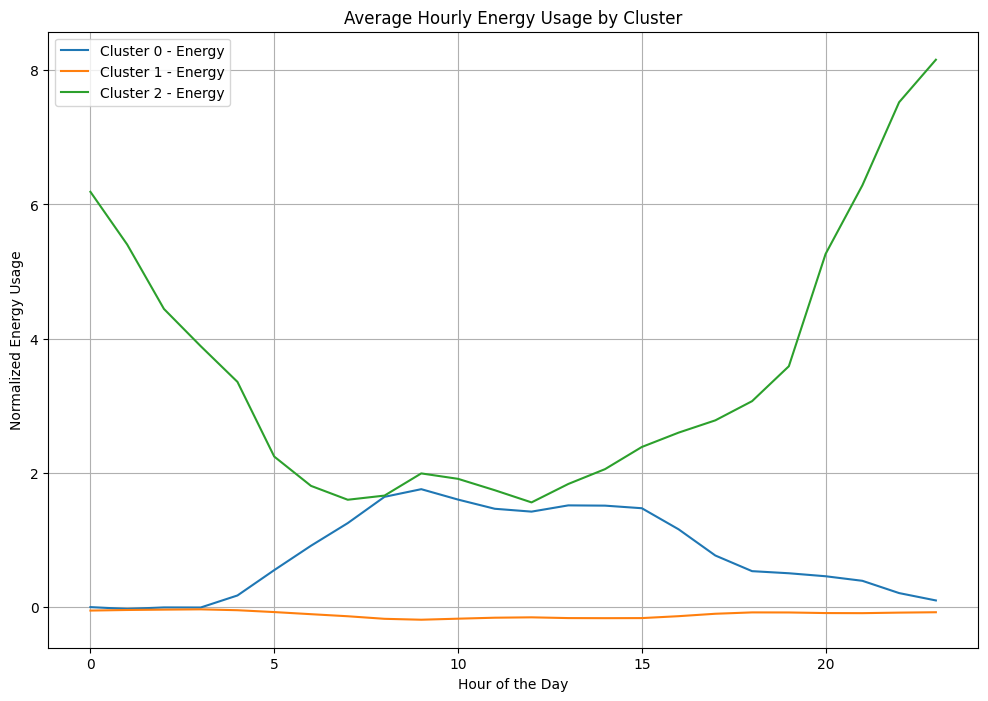

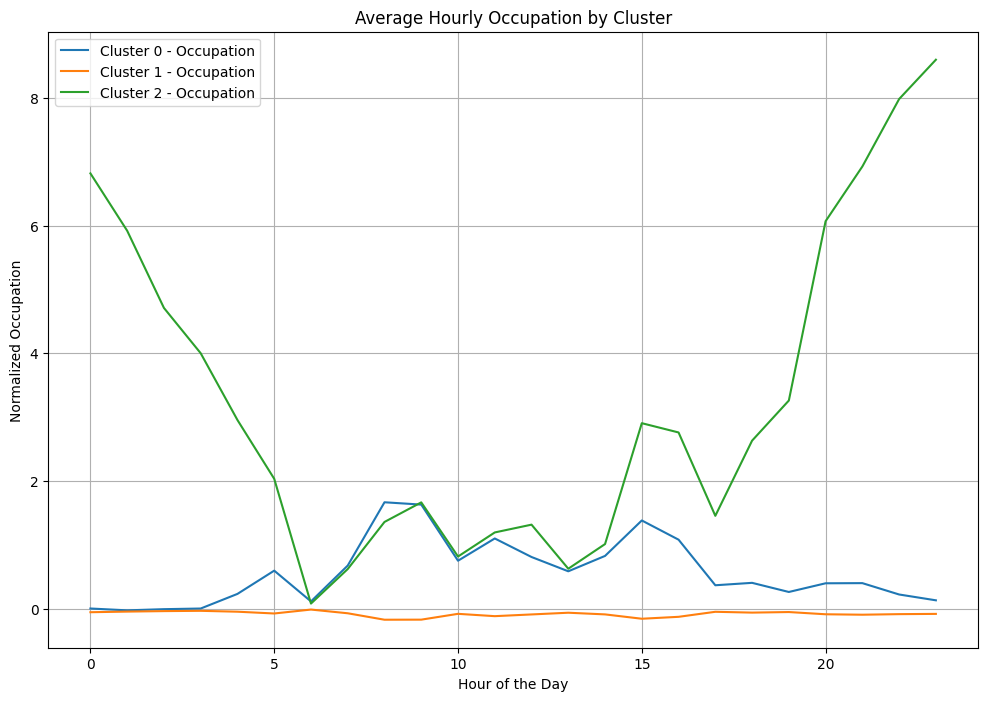

In [77]:
# Calculate cluster averages
cluster_centers_energy = pd.DataFrame(kmeans.cluster_centers_[:, :24], columns=user_hourly_energy.columns[:-1])
cluster_centers_occupation = pd.DataFrame(kmeans.cluster_centers_[:, 24:], columns=user_hourly_occupation.columns)

# Plot average energy usage for each cluster
plt.figure(figsize=(12, 8))
for cluster_id in range(cluster_centers_energy.shape[0]):
    plt.plot(cluster_centers_energy.iloc[cluster_id, :], label=f'Cluster {cluster_id} - Energy')
plt.xlabel('Hour of the Day')
plt.ylabel('Normalized Energy Usage')
plt.title('Average Hourly Energy Usage by Cluster')
plt.legend()
plt.grid()
plt.show()

# Plot average occupation for each cluster
plt.figure(figsize=(12, 8))
for cluster_id in range(cluster_centers_occupation.shape[0]):
    plt.plot(cluster_centers_occupation.iloc[cluster_id, :], label=f'Cluster {cluster_id} - Occupation')
plt.xlabel('Hour of the Day')
plt.ylabel('Normalized Occupation')
plt.title('Average Hourly Occupation by Cluster')
plt.legend()
plt.grid()
plt.show()

In [26]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing values per column:", missing_values)

Missing values per column: Station Name                           0
MAC Address                            0
Org Name                               0
Start Date                             0
Start Time Zone                        0
End Date                               0
End Time Zone                          0
Transaction Date (Pacific Time)      209
Total Duration (hh:mm:ss)              0
Charging Time (hh:mm:ss)               0
Energy (kWh)                           0
GHG Savings (kg)                       0
Gasoline Savings (gallons)             0
Port Type                              9
Port Number                            0
Plug Type                              0
EVSE ID                            78948
Address 1                              0
City                                   0
State/Province                         0
Postal Code                            0
Country                                0
Latitude                               0
Longitude                     

In [27]:
# Drop rows with missing values
cleaned_data = df.dropna()

Know we converting any date-related columns into proper datetime objects.

In [28]:
# Ignoring errors in case of invalid values
cleaned_data['Start Date'] = pd.to_datetime(cleaned_data['Start Date'], errors = 'coerce')
cleaned_data['End Date'] = pd.to_datetime(cleaned_data['End Date'], errors = 'coerce')
print(cleaned_data[['Start Date', 'End Date']].head())

               Start Date            End Date
78948 2016-08-01 05:21:00 2016-08-01 06:49:00
78949 2016-08-01 06:01:00 2016-08-01 10:58:00
78950 2016-08-01 06:03:00 2016-08-01 09:15:00
78951 2016-08-01 06:10:00 2016-08-01 08:54:00
78952 2016-08-01 06:13:00 2016-08-01 09:33:00


/var/folders/c_/q2yk81hd0zj7jnx_b5275pzh0000gn/T/ipykernel_27589/4137332976.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Start Date'] = pd.to_datetime(cleaned_data['Start Date'], errors = 'coerce')
/var/folders/c_/q2yk81hd0zj7jnx_b5275pzh0000gn/T/ipykernel_27589/4137332976.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['End Date'] = pd.to_datetime(cleaned_data['End Date'], errors = 'coerce')


Next, we focus on the numerical columns, ensuring they are in the correct format and free of errors. We will also convert time durations into numeric formats.

In [29]:
def time_to_seconds(time_str):
    if isinstance(time_str, str):
        h, m, s = map(int, time_str.split(':'))
        return h * 3600 + m * 60 + s
    return 0

# Apply the conversion to relevant columns
cleaned_data['Total Duration (seconds)'] = cleaned_data['Total Duration (hh:mm:ss)'].apply(time_to_seconds)
cleaned_data['Charging Time (seconds)'] = cleaned_data['Charging Time (hh:mm:ss)'].apply(time_to_seconds)

print(cleaned_data[['Total Duration (seconds)', 'Charging Time (seconds)', 'Energy (kWh)']].head())

/var/folders/c_/q2yk81hd0zj7jnx_b5275pzh0000gn/T/ipykernel_27589/1859461888.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Total Duration (seconds)'] = cleaned_data['Total Duration (hh:mm:ss)'].apply(time_to_seconds)


       Total Duration (seconds)  Charging Time (seconds)  Energy (kWh)
78948                      5278                     5126      4.464626
78949                     17787                     9064      7.501231
78950                     11537                    11478     10.891753
78951                      9865                     8749      6.968250
78952                     11964                    11955     17.938757


/var/folders/c_/q2yk81hd0zj7jnx_b5275pzh0000gn/T/ipykernel_27589/1859461888.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_data['Charging Time (seconds)'] = cleaned_data['Charging Time (hh:mm:ss)'].apply(time_to_seconds)


Now let's plot some key features to better understand the data.

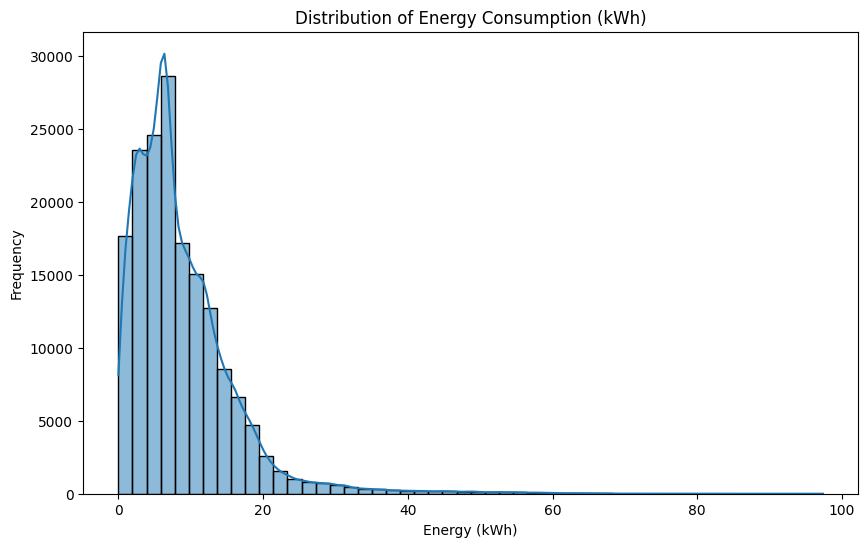

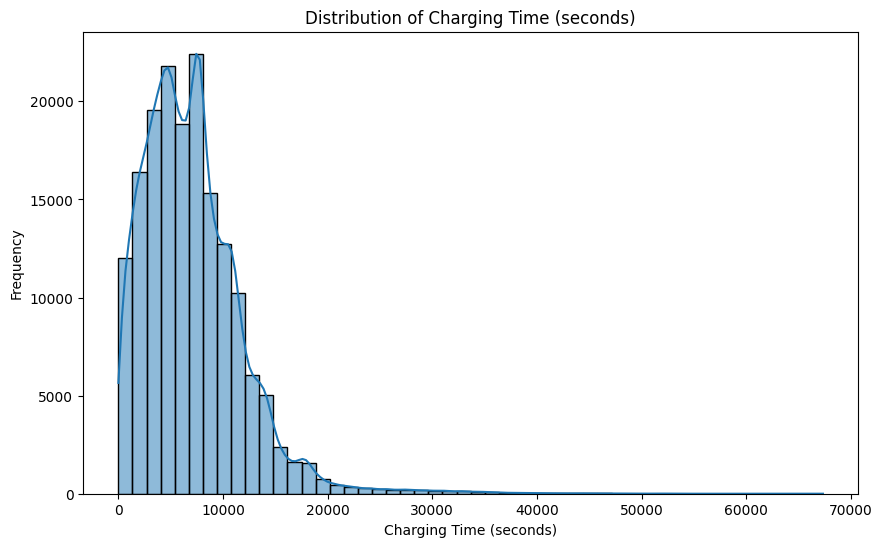

In [30]:
# Plot distribution of energy consumption
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data['Energy (kWh)'], bins=50, kde=True)
plt.title('Distribution of Energy Consumption (kWh)')
plt.xlabel('Energy (kWh)')
plt.ylabel('Frequency')
plt.show()

# Plot charging duration
plt.figure(figsize=(10, 6))
sns.histplot(cleaned_data['Charging Time (seconds)'], bins=50, kde=True)
plt.title('Distribution of Charging Time (seconds)')
plt.xlabel('Charging Time (seconds)')
plt.ylabel('Frequency')
plt.show()

In [34]:
# Convert the 'Charging Time (hh:mm:ss)' to timedelta to facilitate sum calculation
df['Charging Time (hh:mm:ss)'] = pd.to_timedelta(df['Charging Time (hh:mm:ss)'], errors='coerce')

# Extract date from 'Start Date' column for daily aggregation
df['Start Date'] = pd.to_datetime(df['Start Date'], errors='coerce').dt.date

# Group by station and date to calculate total charging time per station per day
daily_usage = df.groupby(['Station Name', 'Start Date', 'Latitude', 'Longitude'])['Charging Time (hh:mm:ss)'].sum().reset_index()

# Calculate average daily charging time per station
avg_daily_usage = daily_usage.groupby(['Station Name', 'Latitude', 'Longitude'])['Charging Time (hh:mm:ss)'].mean().reset_index()

# Convert average daily usage to hours for easier interpretation
avg_daily_usage['avg_daily_energy_hours'] = avg_daily_usage['Charging Time (hh:mm:ss)'].dt.total_seconds() / 3600

# Display the prepared data
avg_daily_usage.head()

,Station Name,Latitude,Longitude,Charging Time (hh:mm:ss),avg_daily_energy_hours
0,PALO ALTO CA / BRYANT # 1,37.446651,-122.161919,0 days 01:54:37.454545454,1.910404
1,PALO ALTO CA / BRYANT #1,37.446373,-122.162331,0 days 03:33:45.517857142,3.562644
2,PALO ALTO CA / BRYANT #1,37.446613,-122.162308,0 days 09:37:01.288401253,9.617025
3,PALO ALTO CA / BRYANT #1,37.446651,-122.161919,0 days 01:44:55.933333333,1.748870
4,PALO ALTO CA / BRYANT #2,37.446373,-122.162331,0 days 03:15:34.650793650,3.259625


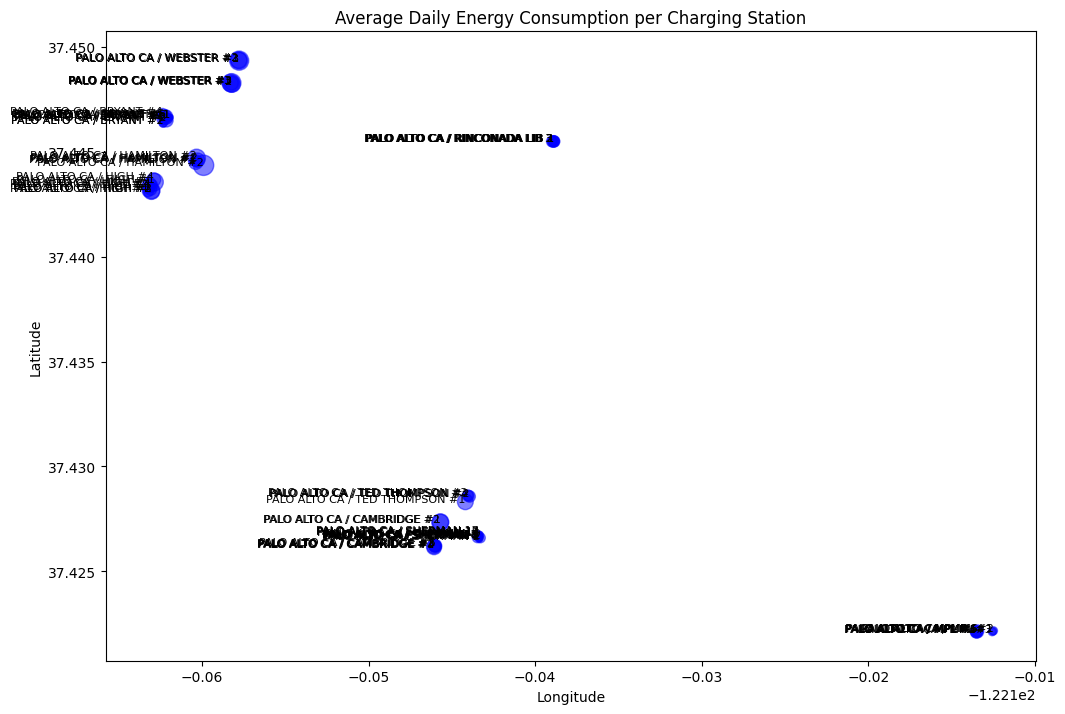

In [44]:
# Convert to GeoDataFrame
gdf_stations = gpd.GeoDataFrame(
    avg_daily_usage,
    geometry=gpd.points_from_xy(avg_daily_usage.Longitude, avg_daily_usage.Latitude), crs="EPSG:4326")

# Plotting
fig, ax = plt.subplots(figsize=(12, 12))

# Plot the stations
gdf_stations.plot(
    ax=ax,
    color="blue",
    markersize=gdf_stations["avg_daily_energy_hours"] * 10,  # Scale factor for visibility
    alpha=0.5,
    legend=True
)

# Adding labels for clarity
for x, y, label in zip(gdf_stations.geometry.x, gdf_stations.geometry.y, gdf_stations["Station Name"]):
    ax.text(x, y, label, fontsize=8, ha="right")

# Plot customization
plt.title("Average Daily Energy Consumption per Charging Station")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# **Mandatory Component**
---

# **Exploratory Component**
---

# **Conclusions**
---